# Forecasting Consensus Expectations: Initial Jobless Claims
## Point and Directional Forecasts

**Imports**

In [2]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from arch.univariate import ConstantMean, GARCH, StudentsT
from arch.univariate.base import ConvergenceWarning
from IPython.display import display, Markdown

In [3]:
OUT_DIR = "../out"
DF_FILE       = "ijc_df.parquet"
DF_FULL_FILE  = "ijc_df_full.parquet"

df       = pd.read_parquet(os.path.join(OUT_DIR, DF_FILE),      engine="pyarrow")
df_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df shape     : (180681, 10)
df_full shape: (213651, 10)


In [4]:
df_full.head()

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise
0,2006-01-05,2005-12-31,320.0,291.0,Michelle Meyer,Mastercard International Inc,NaN,NaT,NaN,-29.0
1,2006-01-05,2005-12-31,320.0,291.0,Michael Derks,Fxpro Financial Services Ltd,NaN,NaT,NaN,-29.0
2,2006-01-05,2005-12-31,320.0,291.0,Michael E Feroli,JP Morgan Securities LLC,NaN,NaT,NaN,-29.0
3,2006-01-05,2005-12-31,320.0,291.0,Michael Gapen,Morgan Stanley & Co LLC,NaN,NaT,NaN,-29.0
4,2006-01-05,2005-12-31,320.0,291.0,Michael Moran,Daiwa Capital Mkts,NaN,NaT,NaN,-29.0


**Data Exploration**

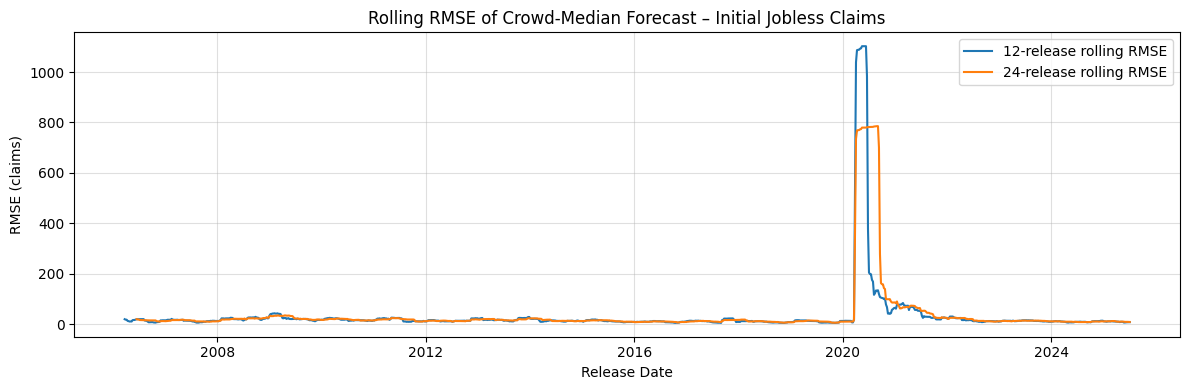

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. One row per release: crowd median vs actual
# ------------------------------------------------------------
median_vs_actual = (
    df_full.groupby("release_date")
           .agg(crowd_median=("forecast", "median"),   # ← economist median
                actual      =("actual",   "first"))
           .dropna()           # drop unreleased weeks
           .sort_index()
)

# ------------------------------------------------------------
# 2. Rolling RMSEs (12- and 24-release windows)
# ------------------------------------------------------------
for W in (12, 24):
    median_vs_actual[f"rmse_{W}"] = (
        median_vs_actual["crowd_median"].sub(median_vs_actual["actual"])
        .rolling(W, min_periods=W)
        .apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
    )

# ------------------------------------------------------------
# 3. Plot
# ------------------------------------------------------------
plt.figure(figsize=(12, 4))

plt.plot(median_vs_actual.index,
         median_vs_actual["rmse_12"],
         label="12-release rolling RMSE")

plt.plot(median_vs_actual.index,
         median_vs_actual["rmse_24"],
         label="24-release rolling RMSE")

plt.title("Rolling RMSE of Crowd-Median Forecast – Initial Jobless Claims")
plt.xlabel("Release Date")
plt.ylabel("RMSE (claims)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
